# Imports

In [2]:
!conda activate TopicModelling

In [1]:
# %pip install google-play-scraper pandas numpy seaborn matplotlib tqdm 
# %pip install pyarrow fastparquet
# %pip install torch transformers
# %pip install sentencepiece

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as plotly_offline
from tqdm import tqdm
tqdm.pandas()
from google_play_scraper import app, Sort, reviews,reviews_all

import torch
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from transformers import pipeline
from torch.utils.data import DataLoader
from torch.nn.functional import softmax

from sklearn.decomposition import LatentDirichletAllocation

# Data Wrangling

## Data Download

In [10]:
help(reviews_all)

Help on function reviews_all in module google_play_scraper.features.reviews:

reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list



In [11]:
# result = reviews_all(
#     'com.paytmmoney',
#     sleep_milliseconds=0, # defaults to 0
#     lang='en', # defaults to 'en'
#     country='us', # defaults to 'us'
#     sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
#     count = 1_00_000
# )
# df = pd.DataFrame(result)
# df.to_parquet('data/external/49k_reviews.parquet')
# df.to_pickle('../data/external/49k_reviews.pkl')

In [12]:
df.shape

(49197, 11)

## Data Transformation

In [22]:
df = pd.read_pickle('../data/external/49k_reviews.pkl')

In [23]:
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a5a66eee-4a3a-4874-b6ba-7a80b1176393,Ritesh Patne,https://play-lh.googleusercontent.com/a/ACg8oc...,The worst feature added is the voice assistant...,1,24,8.9.0824,2023-09-12 19:28:53,"Hello, this is not something we would want you...",2023-09-13 10:34:15,8.9.0824
1,06d47fe6-853d-46ca-b3aa-e08a41d1287b,Anshika Gupta,https://play-lh.googleusercontent.com/a-/ALV-U...,The Re-kyc page doesn't load at all. I tried t...,1,0,8.9.0905,2023-09-13 20:33:01,"Hello, this is not something we would want you...",2023-09-14 11:55:55,8.9.0905
2,cf2e5afd-21e9-4c44-822f-1b991d679b8e,Dipam Shah,https://play-lh.googleusercontent.com/a-/ALV-U...,"Worst Experience ever : Pathetic load times, C...",1,3,8.9.0905,2023-09-12 06:13:06,"Hello, this is not something we would want you...",2023-09-12 10:31:18,8.9.0905


In [24]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [29]:
df.dtypes

reviewId                        object
userName                        object
userImage                       object
content                         object
score                            int64
thumbsUpCount                    int64
reviewCreatedVersion            object
at                      datetime64[ns]
replyContent                    object
repliedAt               datetime64[ns]
appVersion                      object
dtype: object

In [28]:
df.isna().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    10044
at                          0
replyContent            10711
repliedAt               10711
appVersion              10044
dtype: int64

# Exploration

In [139]:
fig_save_path = '../reports/figures'

In [30]:
df = pd.read_pickle('../data/external/49k_reviews.pkl')

## Playstore rating scores

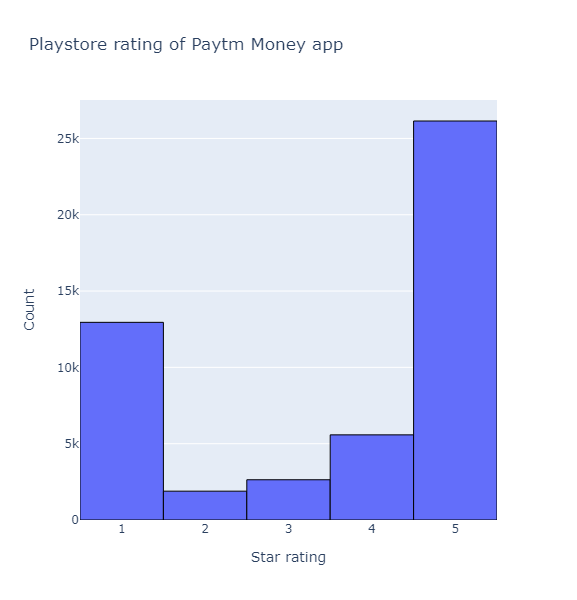

'../reports/figures/playstore_ratings_histogram.html'

In [140]:
# # Star ratings

fig = px.histogram(df, x='score', nbins=5, title='Playstore rating of Paytm Money app')
fig.update_xaxes(title='Star rating', tickvals=[1, 2, 3, 4, 5], ticktext=['1', '2', '3', '4', '5'])
fig.update_yaxes(title='Count')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
fig.update_layout(width=600, height=600)
fig.show()

# plotly_offline.plot(fig,filename = f'{fig_save_path}/playstore_ratings_histogram.html',auto_open = False)

## Average Thumbs-Up Count by Star Rating

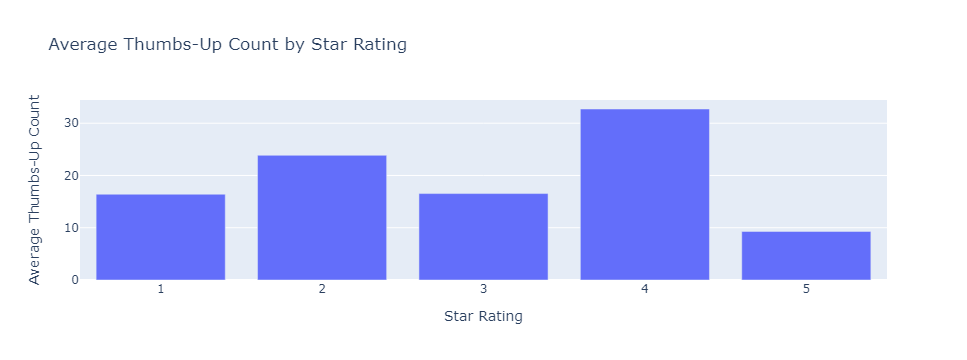

Highest Average Thumbs-Up Count: Star Rating score            4
thumbsUpCount    3
dtype: int64
Lowest Average Thumbs-Up Count: Star Rating score            0
thumbsUpCount    4
dtype: int64


'../reports/figures/Average Thumbs-Up Count by Star Rating.html'

In [141]:
# Rating vs thumbsup count
filtered_df = df[df['thumbsUpCount'] > 0]
average_thumbsup_by_rating = filtered_df.groupby('score')['thumbsUpCount'].mean().reset_index()
# plt.figure(figsize=(8, 6))
# average_thumbsup_by_rating.plot(kind='bar', edgecolor='black', color='skyblue')
# plt.xlabel('Star Rating')
# plt.ylabel('Average Thumbs-Up Count')
# plt.title('Average Thumbs-Up Count by Star Rating')
# plt.xticks(rotation=0)
# plt.show()

fig = px.bar(
    average_thumbsup_by_rating,
    x='score',
    y='thumbsUpCount',
    title='Average Thumbs-Up Count by Star Rating',
    labels={'score': 'Star Rating', 'thumbsUpCount': 'Average Thumbs-Up Count'},
)
fig.show()

highest_average_rating = average_thumbsup_by_rating.idxmax()
lowest_average_rating = average_thumbsup_by_rating.idxmin()

print(f'Highest Average Thumbs-Up Count: Star Rating {highest_average_rating}')
print(f'Lowest Average Thumbs-Up Count: Star Rating {lowest_average_rating}')

plotly_offline.plot(fig,filename = f'{fig_save_path}/Average Thumbs-Up Count by Star Rating.html',auto_open = False)

## Rating over time

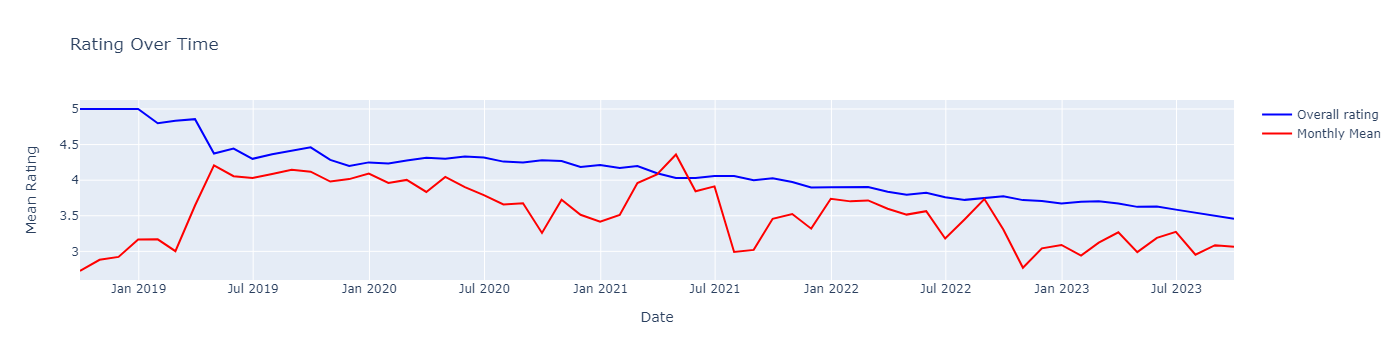

'../reports/figures/Rating over time.html'

In [180]:
# df['at'] = pd.to_datetime(df['at'])
df.sort_values(by='at', inplace=True)
# df.set_index('at', inplace=True)

monthly_mean_ratings = df['score'].resample('M').mean().reset_index()
df['Overall_Rating'] = df['score'].expanding().mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_mean_ratings['at'], y=df['Overall_Rating'], mode='lines', name='Overall rating', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=monthly_mean_ratings['at'], y=monthly_mean_ratings['score'], mode='lines', name='Monthly Mean', line=dict(color='red')))
fig.update_layout(
    title='Rating Over Time',
    xaxis_title='Date',
    yaxis_title='Mean Rating'
)
fig.update_layout(width=800, height=300)
fig.show()

# plotly_offline.plot(fig,filename = f'{fig_save_path}/Rating over time.html',auto_open = False)

# Sentiment Analysis

In [4]:
df = pd.read_pickle('../data/external/49k_reviews.pkl')

In [5]:
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a5a66eee-4a3a-4874-b6ba-7a80b1176393,Ritesh Patne,https://play-lh.googleusercontent.com/a/ACg8oc...,The worst feature added is the voice assistant...,1,24,8.9.0824,2023-09-12 19:28:53,"Hello, this is not something we would want you...",2023-09-13 10:34:15,8.9.0824
1,06d47fe6-853d-46ca-b3aa-e08a41d1287b,Anshika Gupta,https://play-lh.googleusercontent.com/a-/ALV-U...,The Re-kyc page doesn't load at all. I tried t...,1,0,8.9.0905,2023-09-13 20:33:01,"Hello, this is not something we would want you...",2023-09-14 11:55:55,8.9.0905
2,cf2e5afd-21e9-4c44-822f-1b991d679b8e,Dipam Shah,https://play-lh.googleusercontent.com/a-/ALV-U...,"Worst Experience ever : Pathetic load times, C...",1,3,8.9.0905,2023-09-12 06:13:06,"Hello, this is not something we would want you...",2023-09-12 10:31:18,8.9.0905


## Pretrained XL NET

In [5]:
# Load the pretrained XLNet model and tokenizer
model_name = "xlnet-base-cased"
model = XLNetForSequenceClassification.from_pretrained(model_name)
tokenizer = XLNetTokenizer.from_pretrained(model_name)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


C:\Users\DELL\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



In [12]:
num_samples_to_process = 160
mini_df = df.sample(num_samples_to_process)
reviews = mini_df['content'].tolist()
encoded_reviews = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt", max_length=128)
# Convert star ratings to sentiment labels
sentiment_labels = []
for rating in mini_df['score']:
    if rating >= 4:
        sentiment_labels.append("positive")
    elif rating <= 2:
        sentiment_labels.append("negative")
    else:
        sentiment_labels.append("neutral")
        
# Create DataLoader for inference
dataset = torch.utils.data.TensorDataset(encoded_reviews["input_ids"], encoded_reviews["attention_mask"])
dataloader = DataLoader(dataset, batch_size=32)

In [13]:
# Initialize lists to store sentiment predictions
predicted_sentiments = []
# Set model to evaluation mode
model.eval()
# Iterate through data in batches
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        input_ids, attention_mask = batch

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted probabilities and labels
        probabilities = softmax(outputs.logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1).tolist()

        # Map labels to sentiment categories (adjust as needed)
        sentiment_mapping = {0: "negative", 1: "neutral", 2: "positive"}
        predicted_sentiments.extend([sentiment_mapping[label] for label in predicted_labels])

mini_df['sentiment_xlnet'] = predicted_sentiments

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]


In [14]:
mini_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment_xlnet
34465,283825c3-49cc-45fe-ae86-1b8986535225,Cute Cat Clouds,https://play-lh.googleusercontent.com/a-/ALV-U...,Great,5,0,6.4.0405,2021-04-14 20:55:07,"Hi, Thank you for your encouraging words and a...",2021-04-14 23:58:03,6.4.0405,negative
12114,36c1cb1c-dc72-45fc-9b50-0a30d5f0d126,Akshay Sharma,https://play-lh.googleusercontent.com/a-/ALV-U...,I couldn't access my f&o dashboard and my orde...,1,0,8.0.1004,2022-10-18 10:00:25,"Hi Akshay, sorry for the inconvenience We reco...",2022-10-18 12:01:48,8.0.1004,negative
36942,6324934d-ec8d-4811-b0d7-af761faca621,initeshtiwari 1404,https://play-lh.googleusercontent.com/a-/ALV-U...,Good app,5,0,4.1.0610,2020-06-18 13:02:53,None,NaT,4.1.0610,negative
31864,b68731cb-a5d4-44d0-ab50-2622f4ebee38,Kanav Gupta,https://play-lh.googleusercontent.com/a/ACg8oc...,Excellent interface,5,0,7.1.1115,2021-12-07 08:25:29,"Hi Kanav, Thank you so much for rating us with...",2021-12-07 08:41:20,7.1.1115,negative
14,76e9bebe-8cf9-4d9d-90b1-477e26c0c7ba,Shailaja,https://play-lh.googleusercontent.com/a/ACg8oc...,No implementation even after a month... Hello ...,1,157,8.7.0619,2023-07-02 22:55:30,"Hey Shailaja, we will take this feedback and g...",2023-02-20 12:38:25,8.7.0619,neutral


In [15]:
mini_df['sentiment_xlnet'].value_counts()

negative    153
neutral       7
Name: sentiment_xlnet, dtype: int64

## Distilbert-base-uncased-emotion

In [11]:
classifier = pipeline("text-classification",model='nlptown/bert-base-multilingual-uncased-sentiment', return_all_scores=True)

## Sample

In [14]:
prediction = classifier("I hate using transformers. The worst part is wide range of support and its very difficult to use")

In [15]:
print(prediction)

[[{'label': '1 star', 'score': 0.6409701704978943}, {'label': '2 stars', 'score': 0.3251630663871765}, {'label': '3 stars', 'score': 0.030114950612187386}, {'label': '4 stars', 'score': 0.0025942374486476183}, {'label': '5 stars', 'score': 0.0011575821554288268}]]


## Whole dataset

In [18]:
df['sentiment_1'] = df['content'].progress_apply(lambda x:classifier(x))

100%|████████████████████████████████████████████████████████████████████████████| 49197/49197 [49:29<00:00, 16.57it/s]


In [19]:
df.to_pickle('../data/interim/reviews_sentiment1.pkl')

# Preprocessing

In [23]:
def clean_text(text):
    le=WordNetLemmatizer()
    word_tokens=word_tokenize(text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    cleaned_text=" ".join(tokens)
    return cleaned_text

In [24]:
df['clean_text'] = df['content'].apply(clean_text)
df.drop(['content'],axis=1,inplace=True)

In [ ]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)
vect_text=vect.fit_transform(df['clean_text'])

In [ ]:
idf=vect.idf_

In [ ]:
dd=dict(zip(vect.get_feature_names(), idf))
l=sorted(dd, key=(dd).get)
# print(l)
print(l[0],l[-1])

In [ ]:
df['clean_text'].head()

# Topic Modelling

## LSA

In [ ]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [ ]:
print(lsa_top[0])
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

In [ ]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

## LDA

In [ ]:
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 

In [ ]:
lda_top=lda_model.fit_transform(vect_text)

In [ ]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

### Wordcloud

In [ ]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
    imp_words_topic=""
    comp=lda_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:25]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=900, height=600).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
draw_word_cloud(0) # Topic 0